# 
# L1 (Lasso) and L2 (Ridge) Regularization in PyTorch
# 
### This notebook demonstrates L1 and L2 regularization using PyTorch. 

In [18]:


import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from ipywidgets import interact

In [23]:

# Set plotting style
plt.style.use('ggplot')
%matplotlib inline

# Generate Synthetic Data
np.random.seed(42)

n_samples = 100
n_features = 30
n_informative = 5

# Create the "true" weights
w_true = np.zeros(n_features)
w_true[:n_informative] = 5 * np.random.rand(n_informative)
w_true[1] = -8
w_true[3] = 6
b_true = 2.5

# Generate X and y with noise
X_np = np.random.randn(n_samples, n_features)
# y = X @ matmul W + b
# y = Wx + b
y_np = X_np @ w_true + b_true + np.random.randn(n_samples) * 1.5

print(f"X_np shape: {X_np.shape}")
print(f"y_np shape: {y_np.shape}")

X_np shape: (100, 30)
y_np shape: (100,)


/var/folders/7x/39m34jlx5r965vt1zd94ntf00000gn/T/ipykernel_27426/4176743929.py:23: RuntimeWarning: divide by zero encountered in matmul
  y_np = X_np @ w_true + b_true + np.random.randn(n_samples) * 1.5
/var/folders/7x/39m34jlx5r965vt1zd94ntf00000gn/T/ipykernel_27426/4176743929.py:23: RuntimeWarning: overflow encountered in matmul
  y_np = X_np @ w_true + b_true + np.random.randn(n_samples) * 1.5
/var/folders/7x/39m34jlx5r965vt1zd94ntf00000gn/T/ipykernel_27426/4176743929.py:23: RuntimeWarning: invalid value encountered in matmul
  y_np = X_np @ w_true + b_true + np.random.randn(n_samples) * 1.5


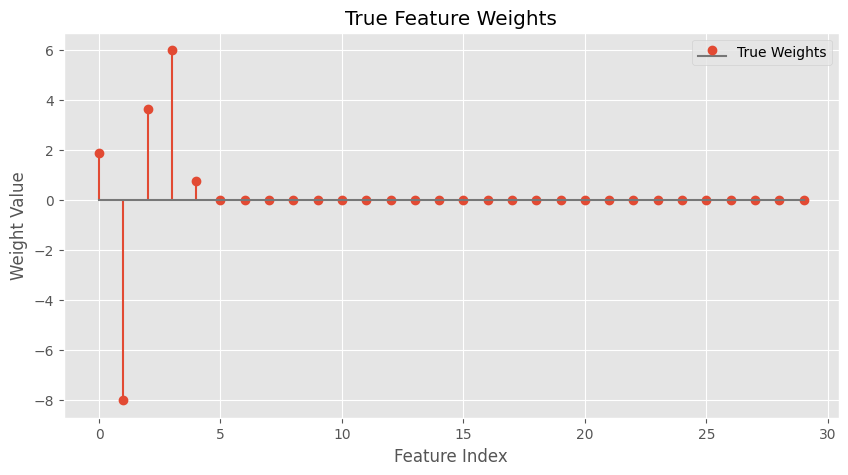

In [24]:

# Plot the true weights
plt.figure(figsize=(10, 5))
plt.stem(w_true, label='True Weights')
plt.title('True Feature Weights')
plt.xlabel('Feature Index')
plt.ylabel('Weight Value')
plt.legend()
plt.show()

In [25]:
# Linear regression using Pytorch

X_tensor = torch.tensor(X_np, dtype=torch.float32)

# y_tensor needs to be a column vector for the loss function (n_samples, 1)
y_tensor = torch.tensor(y_np, dtype=torch.float32).reshape(-1, 1)

# 
# PyTorch's `nn.Linear` module is a single layer that applies a linear transformation:
# $y = Xw^T + b$. This is our entire linear regression model.
# nn.Linear(input_features, output_features)
model_plain = nn.Linear(n_features, 1)
model_l1 = nn.Linear(n_features, 1)
model_l2 = nn.Linear(n_features, 1)

# Ensure all models start from the same (or similar) random weights for a fair comparison
model_l1.load_state_dict(model_plain.state_dict())
model_l2.load_state_dict(model_plain.state_dict())

learning_rate = 0.01
n_epochs = 2000

# Regularization strengths
alpha_l1 = 0.5  # L1 (Lasso) strength
alpha_l2 = 1.0  # L2 (Ridge) strength

# Loss function
criterion = nn.MSELoss()

In [14]:
# Train the Models
# 
# Notice how we **do not compute any gradients manually**. We just call `loss.backward()` and `optimizer.step()`.
# 

# ### Model 1: Plain Linear Regression

optimizer_plain = optim.SGD(model_plain.parameters(), lr=learning_rate)

for epoch in range(n_epochs):
    # Forward pass
    y_pred = model_plain(X_tensor)
    loss = criterion(y_pred, y_tensor)
    
    # Backward pass and optimization
    optimizer_plain.zero_grad() # Clear old gradients
    loss.backward()             # Compute new gradients
    optimizer_plain.step()      # Update weights


In [26]:
# ### Model 2: L2 (Ridge) Regression
# 
# The easiest way to do L2 in PyTorch is to use the `weight_decay` parameter in the optimizer.
#

optimizer_l2 = optim.SGD(model_l2.parameters(), lr=learning_rate, weight_decay=alpha_l2)

for epoch in range(n_epochs):
    # Forward pass
    y_pred = model_l2(X_tensor)
    loss = criterion(y_pred, y_tensor) # Note: loss is just MSE
    
    # Backward and optimize
    # PyTorch automatically adds the L2 penalty gradient during the backward pass
    optimizer_l2.zero_grad()
    loss.backward()
    optimizer_l2.step()


In [27]:
# ### Model 3: L1 (Lasso) Regression
# 
# There is no built-in `weight_decay` for L1, so we add the penalty to the loss manually. 
# We only penalize the weights (`model_l1.weight`), not the bias term.

optimizer_l1 = optim.SGD(model_l1.parameters(), lr=learning_rate)

for epoch in range(n_epochs):
    # Forward pass
    y_pred = model_l1(X_tensor)
    
    # Calculate MSE loss
    mse_loss = criterion(y_pred, y_tensor)
    
    # Calculate L1 penalty
    # We sum the absolute values of the weights (not the bias)
    l1_penalty = alpha_l1 * torch.abs(model_l1.weight).sum()
    
    # Add the penalty to the loss
    total_loss = mse_loss + l1_penalty
    
    # Backward and optimize
    optimizer_l1.zero_grad()
    total_loss.backward() # Autograd figures out the gradient for abs()
    optimizer_l1.step()


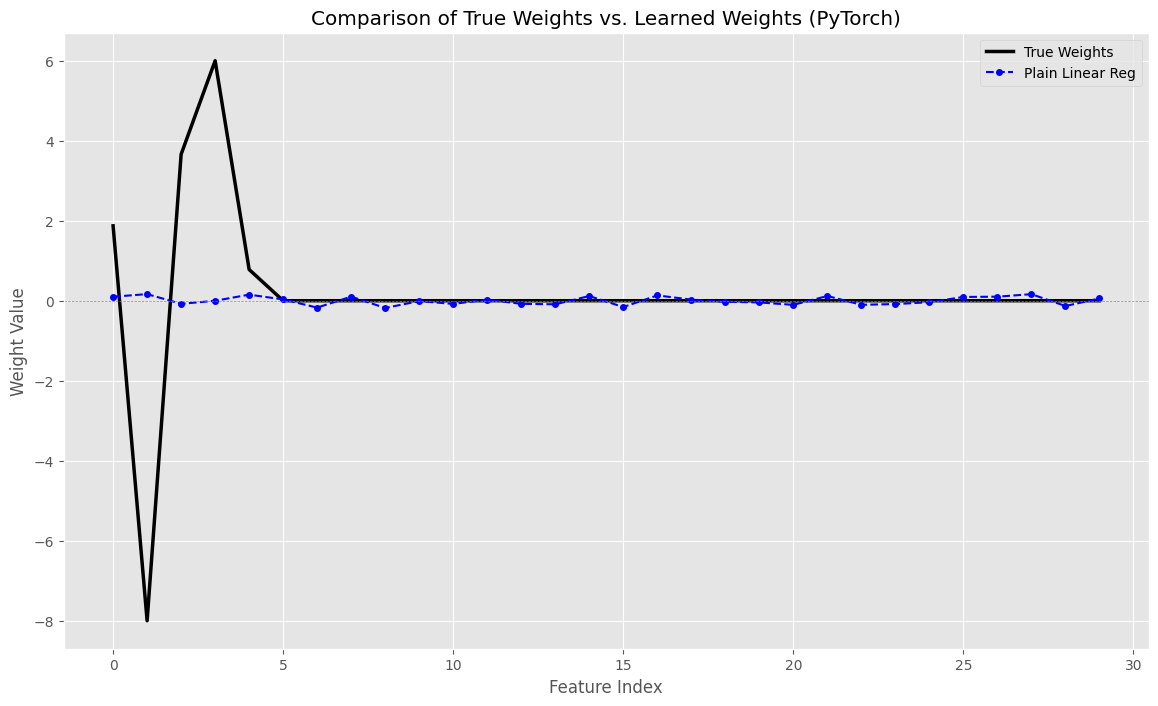

In [28]:
# Visualize Results
 
w_plain = model_plain.weight.data.numpy().flatten()
w_l2 = model_l2.weight.data.numpy().flatten()
w_l1 = model_l1.weight.data.numpy().flatten()


# Plot the results
plt.figure(figsize=(14, 8))
x_axis = np.arange(n_features)

# Plot each set of weights
plt.plot(x_axis, w_true, 'k-', linewidth=2.5, label='True Weights')
plt.plot(x_axis, w_plain, 'b--', marker='o', markersize=4, label='Plain Linear Reg')
#plt.plot(x_axis, w_l2, 'g-.', marker='s', markersize=4, label=f'L2 (Ridge, alpha={alpha_l2})')
#plt.plot(x_axis, w_l1, 'r:', marker='x', markersize=6, label=f'L1 (Lasso, alpha={alpha_l1})')

# Add a line at y=0 for reference
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)

plt.xlabel('Feature Index')
plt.ylabel('Weight Value')
plt.title('Comparison of True Weights vs. Learned Weights (PyTorch)')
plt.legend()
plt.grid(True)
plt.show()


# 
# * **Plain Linear Reg (Blue Dashed):** Overfit, with large, noisy weights on all features.

# * **L2 (Ridge, Green Dash-Dot):** All weights are "shrunk" towards zero. The model is less overfit, but no weights are *exactly* zero.
# * **L1 (Lasso, Red Dotted):** 
# The model correctly performed **feature selection**. It forced the weights for most uninformative features (5-29) to be *exactly* zero, identifying the true sparse nature of the problem.

In [30]:
def plot_interactive_weights(show_plain=True, show_l2=True, show_l1=True):
    """
    Plots the weights based on which checkboxes are selected.
    """
    plt.figure(figsize=(14, 8))
    x_axis = np.arange(n_features)
    
    # Always plot the true weights
    plt.plot(x_axis, w_true, 'k-', linewidth=2.5, label='True Weights')
    
    # Conditionally plot the other weights
    if show_plain:
        plt.plot(x_axis, w_plain, 'b--', marker='o', markersize=4, label='Plain Linear Reg')
    
    if show_l2:
        plt.plot(x_axis, w_l2, 'g-.', marker='s', markersize=4, label=f'L2 (Ridge, alpha={alpha_l2})')
    
    if show_l1:
        plt.plot(x_axis, w_l1, 'r:', marker='x', markersize=6, label=f'L1 (Lasso, alpha={alpha_l1})')

    # Add plot details
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
    plt.xlabel('Feature Index')
    plt.ylabel('Weight Value')
    plt.title('Comparison of True Weights vs. Learned Weights (PyTorch)')
    plt.legend()
    plt.grid(True)
    
    # Set y-axis limits for consistent comparison
    # We can get reasonable limits from all combined weights
    all_weights = np.concatenate([w_true, w_plain, w_l1, w_l2])
    plt.ylim(all_weights.min() - 1, all_weights.max() + 1)
    
    plt.show()

# %% [markdown]
# ## 7. Create Interactive Plot
# 
# Now, we use the `interact` function from `ipywidgets` to automatically create checkboxes that are linked to our plotting function. Toggling any checkbox will re-run the function and redraw the plot.

# %%
# Create the interactive plot
interact(plot_interactive_weights, 
         show_plain=False, 
         show_l2=True, 
         show_l1=True
);

interactive(children=(Checkbox(value=False, description='show_plain'), Checkbox(value=True, description='show_…